In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
import shap # shap values
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

# hyperparameter search
import optuna
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # grid/random search
from bayes_opt import BayesianOptimization # bayesian search
from scipy.stats import uniform, randint # probability distributions
from sklearn.feature_selection import VarianceThreshold # variance analysis

# random seed
np.random.seed(42)

In [30]:
# ===============================
# define function for evaluation
# ===============================

def evaluate_regression(xgb_reg, X_train, y_train, y_test, y_pred, k=5):
    # input: xgb_reg = XGBoost regression
    # input: X_train = data training
    # input: y_train = target training
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test
    # input: y_pred = is the y values (here energy) predicted for the X_test
    # checked on 19/05/2024
    
    # Evaluate the model using mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")
    
    # Evaluate the model using mean squared error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    
    # Evaluate the model using R-squared (R2) score
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared Score: {r2}")
    
    # Evaluate the model using median absolute error
    medae = median_absolute_error(y_test, y_pred)
    print(f"Median Absolute Error: {medae}")

    # Compute the Mean Absolute Error on relative estimate accuracy: (E_pred-E_true)/E_true
    relative_errors = np.abs((y_pred - y_test) / y_test)
    mae_relative = np.mean(relative_errors)
    print(f"Mean Absolute Error on Relative Estimate Accuracy: {mae_relative}")

    # Perform k-fold cross-validation (e.g., k=5)
    cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
    print("Cross-Validation: %.4f +- %.4f" %(-cv_scores.mean(), cv_scores.std()))

def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, X_valid, y_valid, prob=False):
    # input: score_func = function, like mean_absolute_error for regression
    # input: prob = bool, to use either probability prediction or number/discrete prediction for score function
    # checked 19/05/2024

    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
        y_pred_valid = estimator.predict_proba(X_valid)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
        y_pred_valid = estimator.predict(X_valid)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    accuracy_valid = score_func(y_valid, y_pred_valid)
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Valid Accuracy: {accuracy_valid:.4f}")

    # if I want to plot evolution of training and validation metrics I can either use in build function like in tensorflow or create a list
    # of training scores and validation scores depending on n_estimators/epochs --- but this need computational power --- probably

def evaluation_plot(estimator, y_test, y_pred):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test 
    # input: y_pred = is the y values predicted for the X_test
    # plot the figures from the feedback document of the inital project in applied machine learning 2024 
    # (Diversion, Distribution Residuals and Relative Errors)
    # checked 04/06/2024

    y_test = np.array(y_test) 
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90

    # Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(residuals, bins=100)
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals [m]')
    ax1.set_ylabel('Count')
    #ax1.set_xlim()
    
    ax2.hist(relative_errors, bins=100)
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error [m]')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    #plt.savefig('pictures/mae_distr_100_best.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    plt.xlabel('Label [m]')
    plt.ylabel('Prediction [m]')
    plt.title('Thickness Diversion')
    plt.legend()

    #plt.savefig('pictures/division_100_best.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot the RMSE for training and validation sets
    results = estimator.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)

    # Plot RMSE and MAE metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax1.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax1.plot(x_axis, results['validation_2']['rmse'], label='Validation')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE [m]')
    ax1.set_title('Evolution of the Root Mean Squared Error')

    ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax2.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax2.plot(x_axis, results['validation_2']['mae'], label='Validation')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE [m]')
    ax2.set_title('Evolution of the Mean Absolute Error')
    plt.tight_layout()
    #plt.savefig('pictures/evol_mae_100_best.png', dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
# =======================================
# define functions for feature importance
# =======================================

def PI_mean(estimator, X_train, y_train, X_test, y_test, score_func, num_iterations, num_features):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: score_func = function for metric to evaluate (for example log_loss for classification) - but input has to be (y_test, y_pred)
    # and y_pred is the prediction of X_test
    # input: num_iterations = number of iterations for finding the mean permutation importance
    # input: num_features = how many important features you want
    # checked on 18/05/2024

    permutation_importances_all = []
    estimator.fit(X_train, y_train)
        
    y_pred = estimator.predict(X_test)
    original_error = score_func(y_test, y_pred)
    
    for _ in range(num_iterations):
        permutation_importances = np.zeros(X_train.shape[1])
        
        # Calculate permutation importance for each feature
        for i, col in enumerate(X_train.columns):
            X_test_permuted = X_test.copy()
            X_test_permuted[col] = np.random.permutation(X_test_permuted[col])
    
            # Calculate the error with the permuted feature
            y_pred_permuted = estimator.predict(X_test_permuted)
            permuted_error = score_func(y_test, y_pred_permuted)
            permutation_importances[i] = permuted_error - original_error
        
        permutation_importances_all.append(permutation_importances)
    
    mean_importances = np.mean(permutation_importances_all, axis=0) # mean importance for each feature 
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Mean_Importance': mean_importances})
    feature_importance_df_sorted = feature_importance_df.sort_values(by='Mean_Importance', ascending=False)
    top_features = feature_importance_df_sorted.iloc[:num_features]
    return top_features

def shap_values(estimator, X_train, y_train, num_features, plot=False):
    # input: estimator for the machine learning method
    # input: num_features = integer, number of features you want to know
    # input: plot = bool, plot the SHAP values or not
    # SHAP needs methods which are compatible with SHAP, typically tree-based models like XGBoost, LightGBM, RandomForest
    # checked 19/05/2024
    
    estimator.fit(X_train, y_train)
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X_train)
    shap_summary = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(shap_values).mean(axis=0)
    })

    if plot: 
        shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
    
    # Sort the DataFrame by SHAP importance in descending order
    feature_importance_df_sorted = shap_summary.sort_values(by='Importance', ascending=False)
    top_features = feature_importance_df_sorted.iloc[:num_features]
    return top_features

def test_shap_pi_equal(features_PI, features_shap):
    # input: features_PI = dataframe of the features_PI with at least one column called Feature 
    # input: features_shap = dataframe of the features_shap with at least one column called Feature
    # checked 19/05/2024

    merged_df = pd.merge(features_PI['Feature'], features_shap['Feature'], how='outer', indicator=True)
    count = (merged_df['_merge'] == 'both').sum()
    features = merged_df[merged_df['_merge'] == 'both']

    print('Out of %i features, %i features are equal.' %(len(features_shap['Feature']), count))  
    return features['Feature']

In [4]:
class CFG:
    min_thick_value_train = 1.0

    featuresSmall = ['RGI', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form', 'TermType', 'Aspect',
                     'elevation', 'elevation_from_zmin', 'dist_from_border_km_geom',
                     'slope50', 'slope100', 'slope150', 'slope300', 'slope450', 'slopegfa',
                     'curv_50', 'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'lat', 'dmdtda_hugo',
                     'smb']

    features_train = featuresSmall + ['vx_gfa', 'vy_gfa', 'v50', 'v100', 'v150', 'v300', 'v450', 'vgfa']
    target = 'THICKNESS'
    millan = 'ith_m'
    farinotti = 'ith_f'

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5000, 
                             eval_metric=["mae", "rmse"], random_state=42)

In [5]:
# load the dataset
metadata_file = r"n0_metadata19_hmineq0.0_tmin20050000_mean_grid_100.csv"
#metadata_file = "n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
#metadata_file = "n0_wpics_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv" 
#metadata_file = r"Beginning/metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)

In [6]:
glathida_rgis['THICKNESS'].max(), glathida_rgis.shape, glathida_rgis[glathida_rgis['THICKNESS'] >= 1000].shape

(3144.5, (317015, 59), (1183, 59))

In [7]:
# pre-processing
#glathida_rgis = glathida_rgis.dropna()
#glathida_rgis = glathida_rgis.loc[glathida_rgis['THICKNESS']>=CFG.min_thick_value_train]

# add some features for training
glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']

X = glathida_rgis[CFG.features_train]
y = glathida_rgis[CFG.target]

In [14]:
# Identify columns with NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()

# Print the column names
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [15]:
# split the training set
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42) 

In [16]:
# regression machine learning
eval_set = [(X_train, y_train), (X_test, y_test), (X_valid, y_valid)] #[(X_test, y_test)])

start_time = time.time()
model = CFG.model
model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=eval_set)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

y_pred = model.predict(X_test)

[0]	validation_0-mae:107.89040	validation_0-rmse:150.20306	validation_1-mae:108.39018	validation_1-rmse:152.03751	validation_2-mae:107.34865	validation_2-rmse:148.42127
[1]	validation_0-mae:84.98226	validation_0-rmse:121.69151	validation_1-mae:85.26785	validation_1-rmse:122.99775	validation_2-mae:84.58299	validation_2-rmse:120.33779


C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:69.89926	validation_0-rmse:103.33442	validation_1-mae:70.21565	validation_1-rmse:104.20232	validation_2-mae:69.55312	validation_2-rmse:102.10809
[3]	validation_0-mae:60.04607	validation_0-rmse:90.65881	validation_1-mae:60.39944	validation_1-rmse:91.40562	validation_2-mae:59.87175	validation_2-rmse:90.02621
[4]	validation_0-mae:53.64080	validation_0-rmse:83.00937	validation_1-mae:53.95680	validation_1-rmse:83.49992	validation_2-mae:53.49382	validation_2-rmse:82.66079
[5]	validation_0-mae:49.58502	validation_0-rmse:77.94416	validation_1-mae:49.93503	validation_1-rmse:78.42875	validation_2-mae:49.51522	validation_2-rmse:77.90832
[6]	validation_0-mae:46.87084	validation_0-rmse:74.65370	validation_1-mae:47.32608	validation_1-rmse:75.26850	validation_2-mae:46.89473	validation_2-rmse:74.77124
[7]	validation_0-mae:45.08319	validation_0-rmse:72.14269	validation_1-mae:45.59296	validation_1-rmse:72.88851	validation_2-mae:45.11595	validation_2-rmse:72.37992
[8]	validation_0-ma

In [17]:
# evaluate the regression
print(f"Training time: {training_time:.2f} seconds")
evaluate_regression(model, X_train, y_train, y_test, y_pred, k=5)
test_overfitting(model, mean_absolute_error, X_train, y_train, X_test, y_test, X_valid, y_valid)

Training time: 83.89 seconds
Mean Absolute Error: 17.987432180446913
Mean Squared Error: 1003.5498965184663
Root Mean Squared Error: 31.678855669333547
R-squared Score: 0.9737652211022424
Median Absolute Error: 9.912624158357318
Mean Absolute Error on Relative Estimate Accuracy: 0.5325025673670921
Cross-Validation: 17.1890 +- 0.1280
Training Accuracy: 9.2054
Test Accuracy: 17.9874
Valid Accuracy: 18.0230


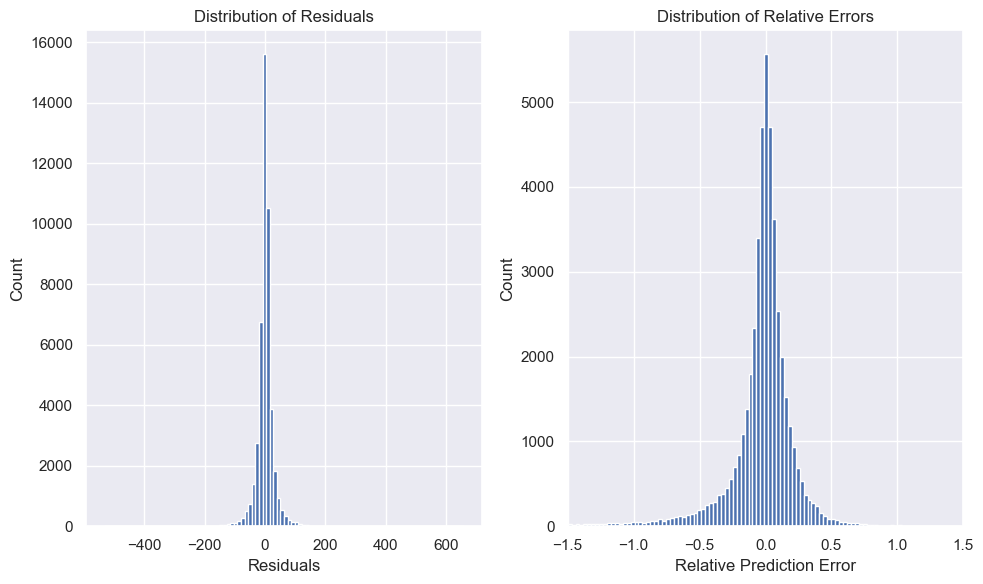

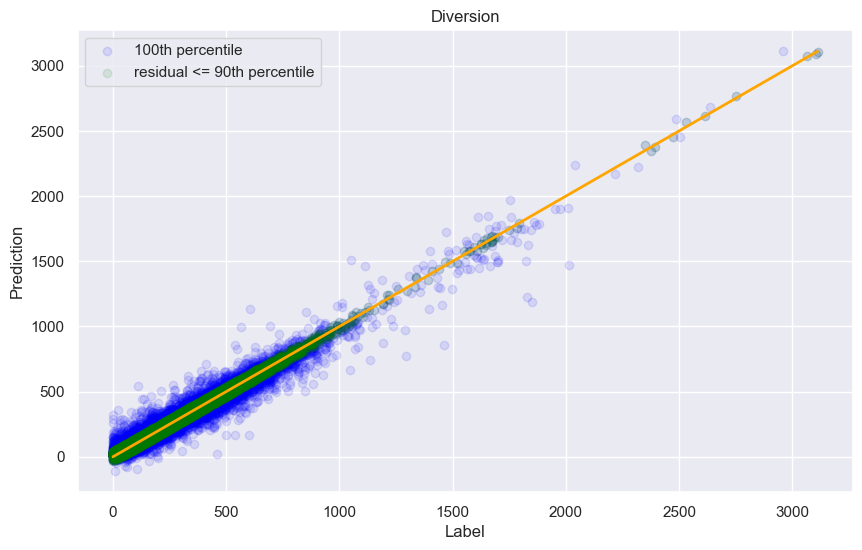

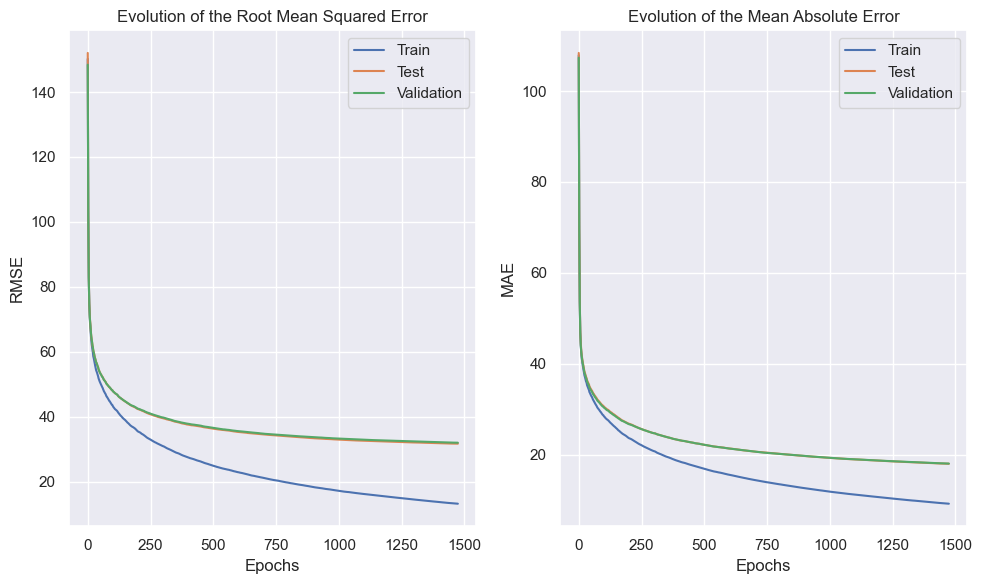

In [18]:
# plot evaluation
evaluation_plot(model, y_test, y_pred)

### Hyperparameter Optimization with Optuna

In [19]:
 glathida_rgis.shape

(317015, 74)

In [20]:
# Define the objective function for Optuna
def objective(trial):
    '''params = {
        'objective': 'reg:squarederror',
        'n_estimators': 5000,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'alpha': trial.suggest_float('alpha', 0, 5),
        'lambda': trial.suggest_float('lambda', 0, 5),
        'random_state': 42
    }'''

    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**params, eval_metric=["mae", "rmse"], early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

# Create Optuna study and optimize
start_time = time.time()
study = optuna.create_study(direction='minimize')
n_trials = 50
study.optimize(objective, n_trials=n_trials)
end_time = time.time()
training_time_optuna = end_time - start_time


# Print the best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

[I 2024-06-09 18:23:05,118] A new study created in memory with name: no-name-ffa5b82c-4715-4fde-8a04-579c9abf33bf
[I 2024-06-09 18:24:00,913] Trial 0 finished with value: 19.225682778821238 and parameters: {'max_depth': 6, 'learning_rate': 0.10561089860995486, 'min_child_weight': 5, 'subsample': 0.6462629190097892, 'gamma': 2.1389975711367963, 'alpha': 0.5671011868455081, 'lambda': 9.24045915180239}. Best is trial 0 with value: 19.225682778821238.
[I 2024-06-09 18:24:52,135] Trial 1 finished with value: 30.266775470092437 and parameters: {'max_depth': 5, 'learning_rate': 0.021185692395882874, 'min_child_weight': 7, 'subsample': 0.6954072906013491, 'gamma': 3.835951368275843, 'alpha': 0.4323874086405829, 'lambda': 3.363288406818525}. Best is trial 0 with value: 19.225682778821238.
[I 2024-06-09 18:26:56,096] Trial 2 finished with value: 14.15090457938116 and parameters: {'max_depth': 10, 'learning_rate': 0.030685679978808996, 'min_child_weight': 4, 'subsample': 0.6890207853739094, 'gamm

Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.07050361375068749, 'min_child_weight': 8, 'subsample': 0.8079570851700261, 'gamma': 2.3034280219712597, 'alpha': 0.6984675615485514, 'lambda': 5.008732091650258}


In [21]:
# print training time of optuna hyperparameter optimization
print(f"Optuna Optimization time: {training_time_optuna:.2f} seconds")

Optuna Optimization time: 4143.03 seconds


In [22]:
X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]

317015

In [ ]:
# train the final model with the best hyperparameters
best_params = study.best_params
start_time = time.time()
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', n_estimators=5000, 
                             eval_metric=["mae", "rmse"], random_state=42)
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)], early_stopping_rounds=5)
end_time = time.time()
training_time_best = end_time - start_time

#y_pred_best = best_model.predict(X_test)

C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:133.71480	validation_0-rmse:181.56214	validation_1-mae:134.43590	validation_1-rmse:183.92529	validation_2-mae:133.08843	validation_2-rmse:179.53546
[1]	validation_0-mae:125.37267	validation_0-rmse:170.85325	validation_1-mae:126.08371	validation_1-rmse:173.16345	validation_2-mae:124.82672	validation_2-rmse:169.03026
[2]	validation_0-mae:117.63428	validation_0-rmse:160.92130	validation_1-mae:118.34507	validation_1-rmse:163.18310	validation_2-mae:117.17567	validation_2-rmse:159.27740
[3]	validation_0-mae:110.44162	validation_0-rmse:151.68470	validation_1-mae:111.16358	validation_1-rmse:153.90935	validation_2-mae:110.05784	validation_2-rmse:150.25532
[4]	validation_0-mae:103.79187	validation_0-rmse:143.11652	validation_1-mae:104.53161	validation_1-rmse:145.33313	validation_2-mae:103.48401	validation_2-rmse:141.89058
[5]	validation_0-mae:97.62679	validation_0-rmse:135.18583	validation_1-mae:98.37157	validation_1-rmse:137.35813	validation_2-mae:97.39528	validation_2-rmse

In [ ]:
y_pred_best = best_model.predict(X_test)

In [25]:
# evaluate the regression
print(f"Training time: {training_time_best:.2f} seconds")
evaluate_regression(best_model, X_train, y_train, y_test, y_pred_best, k=5)
test_overfitting(best_model, mean_absolute_error, X_train, y_train, X_test, y_test, X_valid, y_valid)

Cross-Validation: 13.6539 +- 0.1541
Training Accuracy: 1.2324
Test Accuracy: 12.3406
Valid Accuracy: 12.4476


In [27]:
X_train.shape[0]+X_test.shape[0]+X_valid.shape[0]

317015

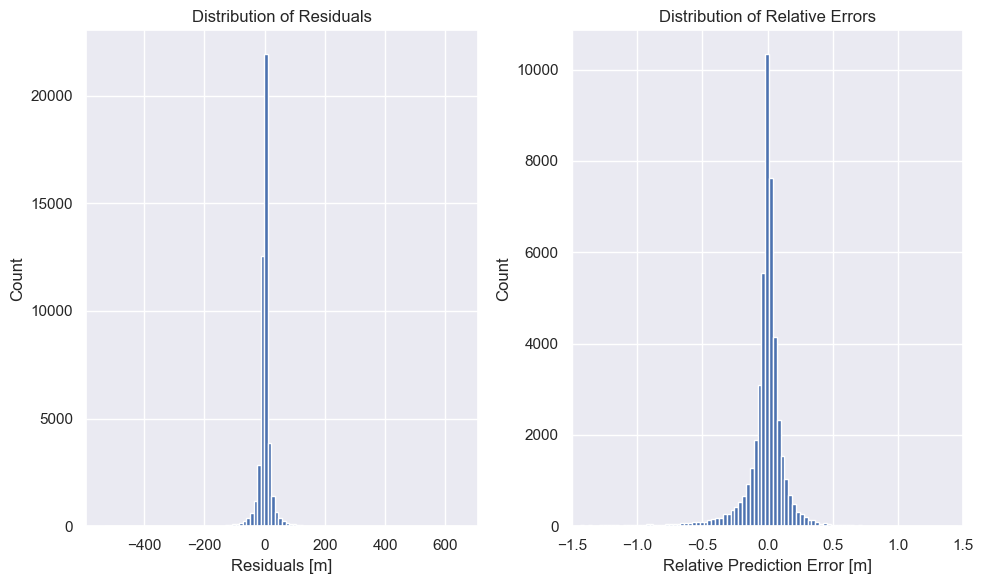

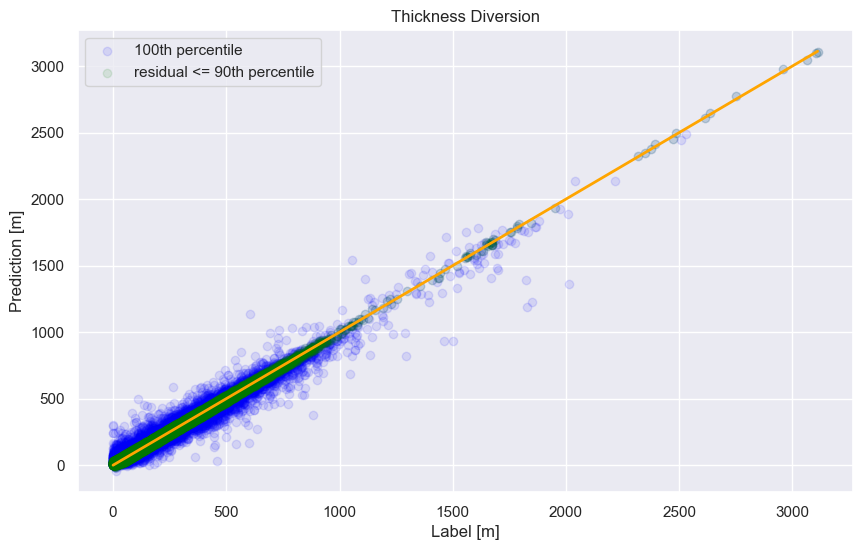

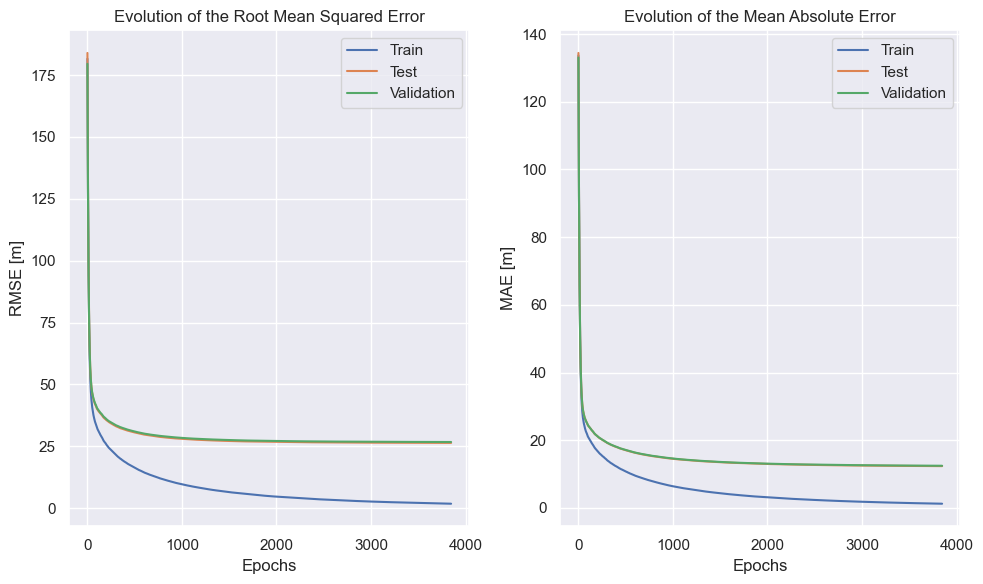

In [31]:
# plot evaluation
evaluation_plot(best_model, y_test, y_pred_best)